In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

**Data preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/nn_project/bowfire'

In [ ]:
classic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(512)
])

mask_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.CenterCrop(512)
])

In [ ]:
im = datasets.ImageFolder(DATASET_PATH + '/im', transform=classic_transform)
gt = datasets.ImageFolder(DATASET_PATH + '/gt', transform=mask_transform)

n = len(im)
n_test = int(0.025 * n)
n_val_div_2 = int(0.075 * n)

test_indexes = list(range(n_test))
train_indexes = list(range(n_val_div_2, n - n_val_div_2))
val_indexes = list(list(range(n_test, n_val_div_2)) + list(range(n - n_val_div_2, n)))

im_test_set = torch.utils.data.Subset(im, test_indexes)
im_val_set = torch.utils.data.Subset(im, val_indexes)
im_train_set = torch.utils.data.Subset(im, train_indexes)

gt_test_set = torch.utils.data.Subset(gt, test_indexes)
gt_val_set = torch.utils.data.Subset(gt, val_indexes)
gt_train_set = torch.utils.data.Subset(gt, train_indexes)

In [ ]:
len(im_test_set)

5

In [ ]:
len(im_val_set)

27

In [ ]:
len(im_train_set)

194

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
batch_size = 1

im_test_loader = torch.utils.data.DataLoader(im_test_set, batch_size=batch_size, shuffle=False)
im_val_loader = torch.utils.data.DataLoader(im_val_set, batch_size=batch_size, shuffle=False)
im_train_loader = torch.utils.data.DataLoader(im_train_set, batch_size=batch_size, shuffle=False)

gt_test_loader = torch.utils.data.DataLoader(gt_test_set, batch_size=batch_size, shuffle=False)
gt_val_loader = torch.utils.data.DataLoader(gt_val_set, batch_size=batch_size, shuffle=False)
gt_train_loader = torch.utils.data.DataLoader(gt_train_set, batch_size=batch_size, shuffle=False)

**Model**

In [ ]:
class MainConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.main_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, inputs):
        x = self.main_conv(inputs)
        return x


In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = MainConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        drop = self.conv(inputs)
        x = self.pool(drop)

        return drop, x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        two_out_channels = out_channels + out_channels
        self.conv = MainConv(two_out_channels, out_channels)

    def forward(self, inputs, drop):
        upper = self.up(inputs)
        concated = torch.cat([upper, drop], axis=1)
        x = self.conv(concated)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = Encoder(3, 64)
        self.down2 = Encoder(64, 128)
        self.down3 = Encoder(128, 256)
        self.down4 = Encoder(256, 512)

        self.middle = MainConv(512, 1024)

        self.up1 = Decoder(1024, 512)
        self.up2 = Decoder(512, 256)
        self.up3 = Decoder(256, 128)
        self.up4 = Decoder(128, 64)

        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        drop1, pool1 = self.down1(inputs)
        drop2, pool2 = self.down2(pool1)
        drop3, pool3 = self.down3(pool2)
        drop4, pool4 = self.down4(pool3)

        middle = self.middle(pool4)

        upper1 = self.up1(middle, drop4)
        upper2 = self.up2(upper1, drop3)
        upper3 = self.up3(upper2, drop2)
        upper4 = self.up4(upper3, drop1)

        outputs = self.outputs(upper4)

        return outputs

In [ ]:
model = UNet()

In [ ]:
model.to(device)

UNet(
  (down1): Encoder(
    (conv): MainConv(
      (main_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Encoder(
    (conv): MainConv(
      (main_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

**Train**

In [ ]:
import copy

In [ ]:
train_history = []
val_history = []

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

n_epochs = 100
best_val_loss = 10000000
best_model_state = "EMPTY"

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data, data_2 in zip(im_train_loader, gt_train_loader):
        images, _ = data
        images_2, _ = data_2

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          outputs = model(images.to(device))
          loss = criterion(outputs, images_2.to(device))
          loss.backward()
          
          optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss = train_loss/len(im_train_loader)
    
    with torch.set_grad_enabled(False):
      val_loss = 0.0
      for val_data, val_data_gt in zip(im_val_loader, gt_val_loader):
        val_images, _ = val_data
        val_images_gt, _ = val_data_gt
        val_outputs = model(val_images.to(device))
        val_loss_func = nn.BCEWithLogitsLoss()
        val_loss += val_loss_func(val_outputs, val_images_gt.to(device)) * val_images.size(0)
    
    val_loss = val_loss / len(im_val_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        val_loss
        ))
    
    train_history.append(float(train_loss))
    val_history.append(float(val_loss))

    # if best_val_loss > val_loss:
    #   print('Model updated!')
    #   best_val_loss = val_loss
    #   best_model_state = copy.deepcopy(model.state_dict())
    

Epoch: 1 	Training Loss: 0.678267 	Val Loss: 0.591974
Epoch: 2 	Training Loss: 0.523115 	Val Loss: 0.497598
Epoch: 3 	Training Loss: 0.463599 	Val Loss: 0.459652
Epoch: 4 	Training Loss: 0.436897 	Val Loss: 0.442286
Epoch: 5 	Training Loss: 0.420344 	Val Loss: 0.430588
Epoch: 6 	Training Loss: 0.405323 	Val Loss: 0.422242
Epoch: 7 	Training Loss: 0.394373 	Val Loss: 0.419541
Epoch: 8 	Training Loss: 0.395474 	Val Loss: 0.407148
Epoch: 9 	Training Loss: 0.373871 	Val Loss: 0.397195
Epoch: 10 	Training Loss: 0.364477 	Val Loss: 0.391450
Epoch: 11 	Training Loss: 0.354212 	Val Loss: 0.384310
Epoch: 12 	Training Loss: 0.345130 	Val Loss: 0.379139
Epoch: 13 	Training Loss: 0.353256 	Val Loss: 0.383338
Epoch: 14 	Training Loss: 0.339723 	Val Loss: 0.380360
Epoch: 15 	Training Loss: 0.329056 	Val Loss: 0.366949
Epoch: 16 	Training Loss: 0.318392 	Val Loss: 0.360937
Epoch: 17 	Training Loss: 0.309912 	Val Loss: 0.357100
Epoch: 18 	Training Loss: 0.301917 	Val Loss: 0.355281
Epoch: 19 	Training

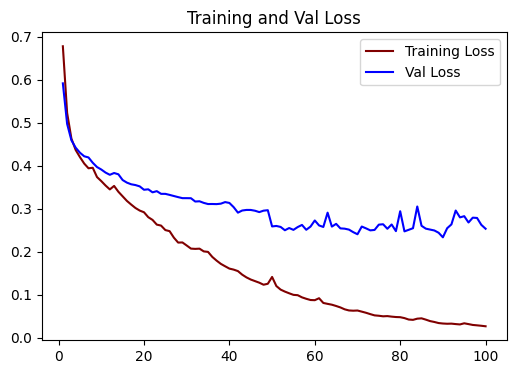

In [ ]:
epochs_range = list(range(1, n_epochs + 1))
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_history, label='Training Loss',
color='maroon')
plt.plot(epochs_range, val_history, label='Val Loss',
color='blue')
plt.legend(loc='upper right')
plt.title('Training and Val Loss')
plt.show()

In [ ]:
torch.save(model, DATASET_PATH + '/unet_4')

In [ ]:
train_history = []
val_history = []

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

n_epochs = 10
best_val_loss = 10000000
best_model_state = "EMPTY"

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data, data_2 in zip(im_train_loader, gt_train_loader):
        images, _ = data
        images_2, _ = data_2

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          outputs = model(images.to(device))
          loss = criterion(outputs, images_2.to(device))
          loss.backward()
          
          optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss = train_loss/len(im_train_loader)
    
    with torch.set_grad_enabled(False):
      val_loss = 0.0
      for val_data, val_data_gt in zip(im_val_loader, gt_val_loader):
        val_images, _ = val_data
        val_images_gt, _ = val_data_gt
        val_outputs = model(val_images.to(device))
        val_loss_func = nn.BCEWithLogitsLoss()
        val_loss += val_loss_func(val_outputs, val_images_gt.to(device)) * val_images.size(0)
    
    val_loss = val_loss / len(im_val_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        val_loss
        ))
    
    train_history.append(float(train_loss))
    val_history.append(float(val_loss))

    # if best_val_loss > val_loss:
    #   print('Model updated!')
    #   best_val_loss = val_loss
    #   best_model_state = copy.deepcopy(model.state_dict())
    

Epoch: 1 	Training Loss: 0.025255 	Val Loss: 0.237558
Epoch: 2 	Training Loss: 0.025475 	Val Loss: 0.276048
Epoch: 3 	Training Loss: 0.027500 	Val Loss: 0.286118
Epoch: 4 	Training Loss: 0.024847 	Val Loss: 0.258709
Epoch: 5 	Training Loss: 0.023265 	Val Loss: 0.272234
Epoch: 6 	Training Loss: 0.023760 	Val Loss: 0.332183
Epoch: 7 	Training Loss: 0.024565 	Val Loss: 0.262050
Epoch: 8 	Training Loss: 0.022429 	Val Loss: 0.281980
Epoch: 9 	Training Loss: 0.020783 	Val Loss: 0.256036
Epoch: 10 	Training Loss: 0.020414 	Val Loss: 0.309527


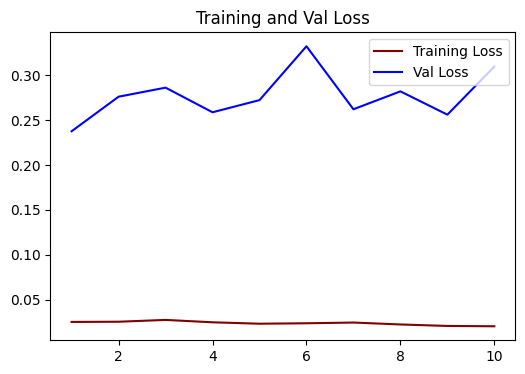

In [ ]:
epochs_range = list(range(1, n_epochs + 1))
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_history, label='Training Loss',
color='maroon')
plt.plot(epochs_range, val_history, label='Val Loss',
color='blue')
plt.legend(loc='upper right')
plt.title('Training and Val Loss')
plt.show()

In [ ]:
torch.save(model, DATASET_PATH + '/unet_4_2')

In [ ]:
train_history = []
val_history = []

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

n_epochs = 10
best_val_loss = 10000000
best_model_state = "EMPTY"

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data, data_2 in zip(im_train_loader, gt_train_loader):
        images, _ = data
        images_2, _ = data_2

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          outputs = model(images.to(device))
          loss = criterion(outputs, images_2.to(device))
          loss.backward()
          
          optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss = train_loss/len(im_train_loader)
    
    with torch.set_grad_enabled(False):
      val_loss = 0.0
      for val_data, val_data_gt in zip(im_val_loader, gt_val_loader):
        val_images, _ = val_data
        val_images_gt, _ = val_data_gt
        val_outputs = model(val_images.to(device))
        val_loss_func = nn.BCEWithLogitsLoss()
        val_loss += val_loss_func(val_outputs, val_images_gt.to(device)) * val_images.size(0)
    
    val_loss = val_loss / len(im_val_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        val_loss
        ))
    
    train_history.append(float(train_loss))
    val_history.append(float(val_loss))

    # if best_val_loss > val_loss:
    #   print('Model updated!')
    #   best_val_loss = val_loss
    #   best_model_state = copy.deepcopy(model.state_dict())
    

Epoch: 1 	Training Loss: 0.021199 	Val Loss: 0.276312
Epoch: 2 	Training Loss: 0.023059 	Val Loss: 0.368785
Epoch: 3 	Training Loss: 0.023486 	Val Loss: 0.455255
Epoch: 4 	Training Loss: 0.037131 	Val Loss: 0.306920
Epoch: 5 	Training Loss: 0.020430 	Val Loss: 0.278060
Epoch: 6 	Training Loss: 0.017883 	Val Loss: 0.261578
Epoch: 7 	Training Loss: 0.017011 	Val Loss: 0.278871
Epoch: 8 	Training Loss: 0.016227 	Val Loss: 0.240787
Epoch: 9 	Training Loss: 0.015927 	Val Loss: 0.243147
Epoch: 10 	Training Loss: 0.015601 	Val Loss: 0.238471


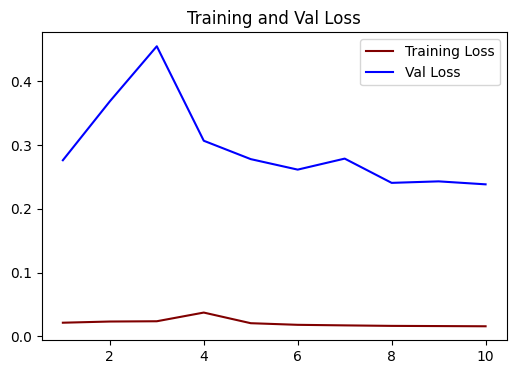

In [ ]:
epochs_range = list(range(1, n_epochs + 1))
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_history, label='Training Loss',
color='maroon')
plt.plot(epochs_range, val_history, label='Val Loss',
color='blue')
plt.legend(loc='upper right')
plt.title('Training and Val Loss')
plt.show()

In [ ]:
torch.save(model, DATASET_PATH + '/unet_4_3')

**Train images test**

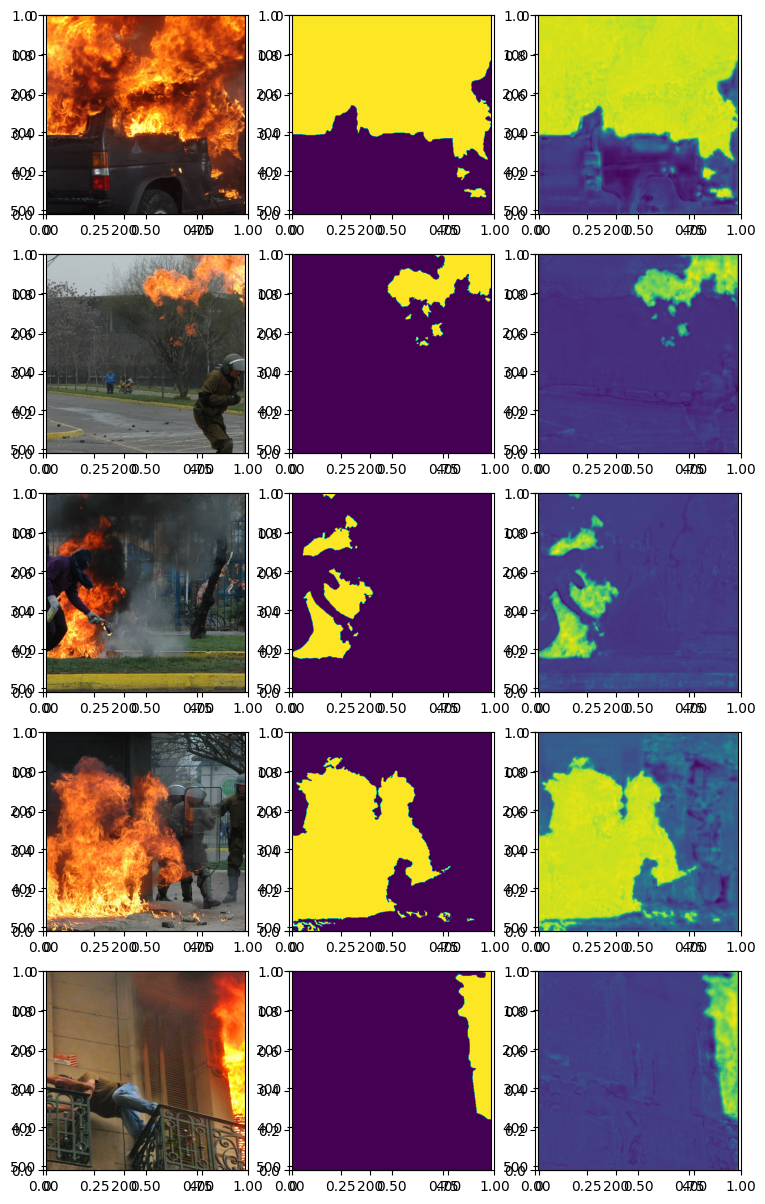

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(9, 15))

for batch_idx, (inputs, labels) in enumerate(im_train_loader):
     ax = fig.add_subplot(5, 3, (batch_idx * 3) + 1)
     plt.imshow(inputs[0:1][0].permute(1, 2, 0).numpy())
     
     if batch_idx > 3:
        break

for batch_idx, (inputs, labels) in enumerate(gt_train_loader):
     ax = fig.add_subplot(5, 3, (batch_idx * 3) + 2)
     plt.imshow(inputs[0:1][0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break

for batch_idx, (inputs, labels) in enumerate(im_train_loader):
     ax = fig.add_subplot(5, 3, (batch_idx * 3) + 3)
     image = inputs[0:1]
     output = model(image.to(device)).detach()
     plt.imshow(output.to('cpu')[0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break

**Test images test**

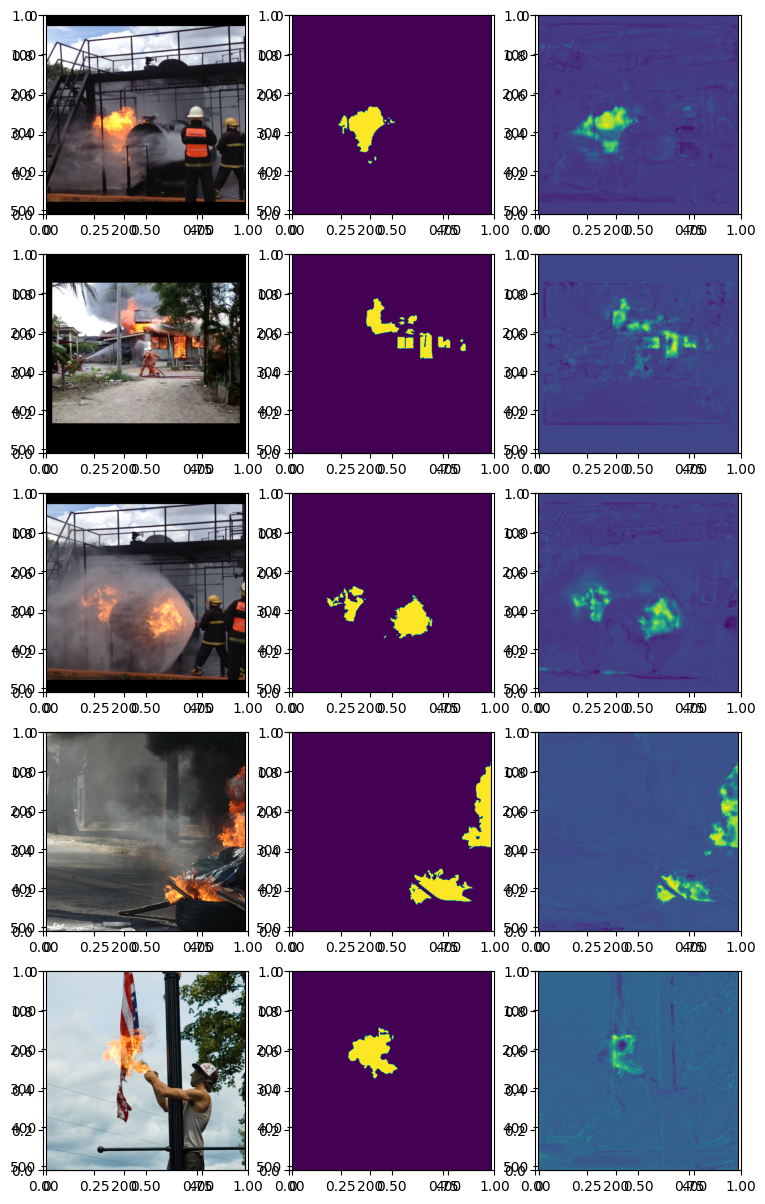

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(9, 15))

for batch_idx, (inputs, labels) in enumerate(im_test_loader):
     ax = fig.add_subplot(5, 3, (batch_idx * 3) + 1)
     plt.imshow(inputs[0:1][0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break

for batch_idx, (inputs, labels) in enumerate(gt_test_loader):
     ax = fig.add_subplot(5, 3, (batch_idx * 3) + 2)
     plt.imshow(inputs[0:1][0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break

for batch_idx, (inputs, labels) in enumerate(im_test_loader):
     ax = fig.add_subplot(5, 3, (batch_idx * 3) + 3)

     image = inputs[0:1]
     output = model(image.to(device)).detach()
     plt.imshow(output.to('cpu')[0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break

**Random internet images test (Out-of-sample)**

In [ ]:
random_images = datasets.ImageFolder(DATASET_PATH + '/random', transform=classic_transform)
batch_size = 1
random_images_loader = torch.utils.data.DataLoader(random_images, batch_size=batch_size, shuffle=False)


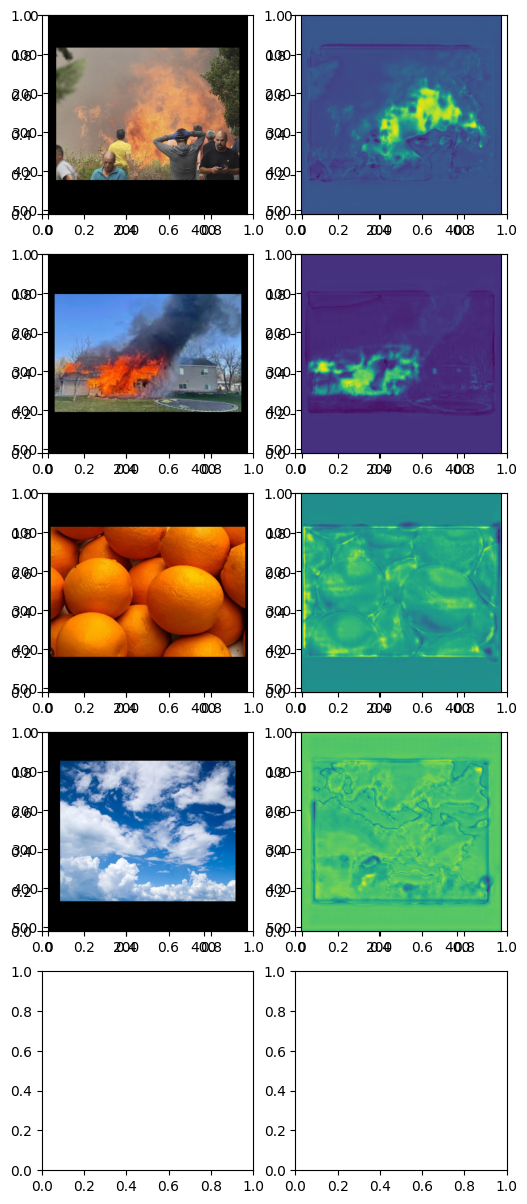

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(6, 15))

for batch_idx, (inputs, labels) in enumerate(random_images_loader):
     ax = fig.add_subplot(5, 2, (batch_idx * 2) + 1)
     plt.imshow(inputs[0:1][0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break

for batch_idx, (inputs, labels) in enumerate(random_images_loader):
     ax = fig.add_subplot(5, 2, (batch_idx * 2) + 2)

     image = inputs[0:1]
     output = model(image.to(device)).detach()
     plt.imshow(output.to('cpu')[0].permute(1, 2, 0).numpy())

     if batch_idx > 3:
        break